# TENAX model

## Importation

In [1]:
from importlib_resources import files
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.stats import chi2
# Import pyTENAX
from pyTENAX import smev, tenax, plotting

## Initiate class and import data rain

In [ ]:
# Initiate TENAX class with customized setup
S = tenax.TENAX(
    return_period=[
        2,
        5,
        10,
        20,
        50,
        100,
        200,
    ],  # for some reason it doesnt like calculating RP =<1
    durations=[10, 60, 180, 360, 720, 1440],
    time_resolution=5,  # time resolution in minutes
    left_censoring=[0, 0.90],
    alpha=0.05,
)

# Paramètres des données
Stations = ['Aigle', 'Pully', 'Payerne', 'Fretaz', 'Dole', 'Nyon']
stat_index = 1
Format = ['Minutes','Heures']
form_index = 0

# Importation et fusion des années 80-95 et 95-24
file_path1 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'8095.txt'
file_path2 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'9524.txt'

df = pd.read_csv(file_path1, sep=";", low_memory=False)
df_temp = pd.read_csv(file_path2, sep=";", low_memory=False)

Overlap_num = df['time'].max()
df_temp = df_temp[df_temp['time'] > Overlap_num]
df = pd.concat([df, df_temp], ignore_index=True)
# Epuration des données et temps/value en format adapté
del df_temp
del df['stn']
df = df.replace('-',0.0)
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
df = df[~df['time'].dt.year.isin([1980, 2025])]
df = df.reset_index(drop=True)
data = df

# Set 'prec_time' as the index
column_name_time = data.columns[0]
column_name_value = data.columns[1]
data.set_index(column_name_time, inplace=True)



## Process rain data

In [3]:
start_time = time.time()
data[column_name_value] = pd.to_numeric(data[column_name_value])
# push values belows 0.1 to 0 in prec due to
data.loc[data[column_name_value] < S.min_rain, column_name_value] = 0

data = S.remove_incomplete_years(data, column_name_value)
print(data)
# get data from pandas to numpy array
df_arr = np.array(data[column_name_value])
df_dates = np.array(data.index)

# extract indexes of ordinary events
# these are time-wise indexes =>returns list of np arrays with np.timeindex
idx_ordinary = S.get_ordinary_events(
    data=df_arr, dates=df_dates, name_col=column_name_value, check_gaps=False
)

# get ordinary events by removing too short events
# returns boolean array, dates of OE in TO, FROM format, and count of OE in each years
arr_vals, arr_dates, n_ordinary_per_year = S.remove_short(idx_ordinary)

# assign ordinary events values by given durations, values are in depth per duration, NOT in intensity mm/h
dict_ordinary, dict_AMS = S.get_ordinary_events_values(
    data=df_arr, dates=df_dates, arr_dates_oe=arr_dates
)

print(f"Elapsed time get OE: {time.time() - start_time:.4f} seconds")

                     rre150z0
time                         
1981-01-01 00:00:00       0.0
1981-01-01 00:10:00       0.0
1981-01-01 00:20:00       0.0
1981-01-01 00:30:00       0.0
1981-01-01 00:40:00       0.0
...                       ...
2024-12-31 23:10:00       0.0
2024-12-31 23:20:00       0.0
2024-12-31 23:30:00       0.0
2024-12-31 23:40:00       0.0
2024-12-31 23:50:00       0.0

[2314224 rows x 1 columns]
Elapsed time get OE: 0.8307 seconds


## Import temperature data

In [11]:
# load temperature data
file_path_temperature_1 = "../Database/Temperatures/Data"+Stations[stat_index]+Format[form_index]+"/Data"+Stations[stat_index]+Format[form_index][0]+"8095.txt"
file_path_temperature_2 = "../Database/Temperatures/Data"+Stations[stat_index]+Format[form_index]+"/Data"+Stations[stat_index]+Format[form_index][0]+"9524.txt"


t_data = pd.read_csv(file_path_temperature_1,  sep=";", low_memory=False)
t_temporary = pd.read_csv(file_path_temperature_2, sep=";", low_memory=False)

last_time = t_data['time'].iloc[-1]
t_temporary_no_overlap = t_temporary[t_temporary['time'] > last_time]
t_data = pd.concat([t_data, t_temporary_no_overlap], ignore_index=True)

# Convert 'temp_time' column to datetime if it's not already in datetime format
del t_data['stn']
Tcolumn_name_time = t_data.columns[0]
t_data[Tcolumn_name_time] = pd.to_datetime(t_data[Tcolumn_name_time], yearfirst=True, utc=False, format='%Y%m%d%H%M')
t_data = t_data[~t_data['time'].dt.year.isin([1980, 2025])]
t_data.replace('-', 0, inplace=True)

# Set 'temp_time' as the index
t_data.set_index(Tcolumn_name_time, inplace=True)
start_time = time.time()
Tcolumn_name_value = t_data.columns[0]
t_data[Tcolumn_name_value] = pd.to_numeric(t_data[Tcolumn_name_value])

t_data = S.remove_incomplete_years(t_data, Tcolumn_name_value)

df_arr_t_data = np.array(t_data[Tcolumn_name_value])
df_dates_t_data = np.array(t_data.index)

dict_ordinary, _, n_ordinary_per_year = S.associate_vars(
    dict_ordinary, df_arr_t_data, df_dates_t_data
)

print(f"Elapsed time : {time.time() - start_time:.4f} seconds")

Elapsed time : 0.9606 seconds


## Process data temperature

In [14]:
start_time = time.time()
# Your data (P, T arrays) and threshold thr=3.8
P = dict_ordinary["10"]["ordinary"].to_numpy()  # Replace with your actual data
T = dict_ordinary["10"]["T"].to_numpy()  # Replace with your actual data
blocks_id = dict_ordinary["10"]["year"].to_numpy()  # Replace with your actual data


# Number of threshold
thr = dict_ordinary["10"]["ordinary"].quantile(S.left_censoring[1])

# Sampling intervals for the Montecarlo
Ts = np.arange(
    np.min(T) - S.temp_delta, np.max(T) + S.temp_delta, S.temp_res_monte_carlo
)

## Tenax model

In [15]:
# TENAX MODEL HERE
# magnitude model
F_phat, loglik, _, _ = S.magnitude_model(P, T, thr)
# temperature model
g_phat = S.temperature_model(T)
# M is mean n of ordinary events
n = n_ordinary_per_year.sum() / len(n_ordinary_per_year)
# estimates return levels using MC samples


RL, _, P_check = S.model_inversion(F_phat, g_phat, n, Ts)
# print(RL)
print(f"Elapsed time TENAX : {time.time() - start_time:.4f} seconds")


Elapsed time TENAX : 2.7008 seconds


## Tenax uncertainty

In [16]:
start_time = time.time()

S.n_monte_carlo = 20000

# tENAX uncertainty
start_time = time.time()
F_phat_unc, g_phat_unc, RL_unc, n_unc, n_err = S.TNX_tenax_bootstrap_uncertainty(
    P, T, blocks_id, Ts
)
print(f"Time to do TENAX uncertainty: {time.time() - start_time:.4f} seconds")

# SMEV and its uncertainty
start_time = time.time()
# TODO: clean this part cause it is a bit messy with namings
S_SMEV = smev.SMEV(
    threshold=0.1,
    separation=24,
    return_period=S.return_period,
    durations=S.durations,
    time_resolution=5,  # time resolution in minutes
    min_duration=30,
    left_censoring=[S.left_censoring[1], 1],
)

# estimate shape and  scale parameters of weibull distribution
smev_shape, smev_scale = S_SMEV.estimate_smev_parameters(P, S_SMEV.left_censoring)
# estimate return period (quantiles) with SMEV
smev_RL = S_SMEV.smev_return_values(
    S_SMEV.return_period, smev_shape, smev_scale, n.item()
)

smev_RL_unc = S_SMEV.SMEV_bootstrap_uncertainty(P, blocks_id, S.niter_smev, n.item())
print(f"Time to do SMEV and uncertainty: {time.time() - start_time:.4f} seconds")

Time to do TENAX uncertainty: 148.7631 seconds
Time to do SMEV and uncertainty: 0.0346 seconds


## First graphs

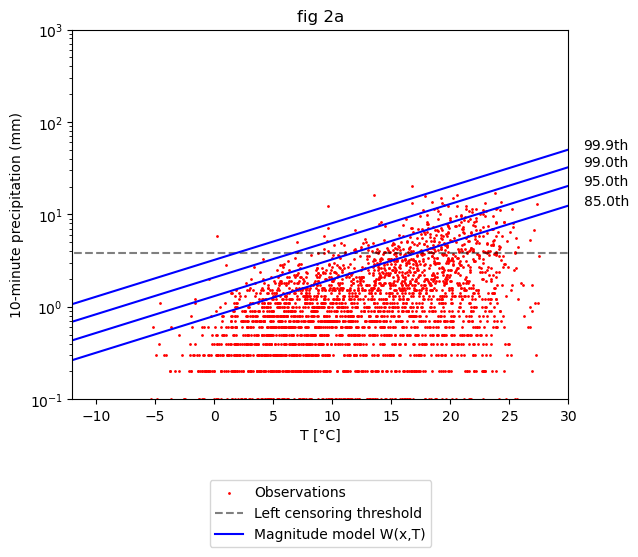

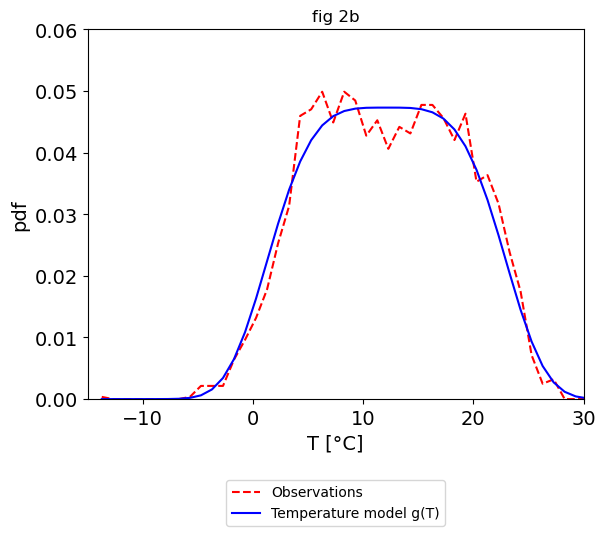

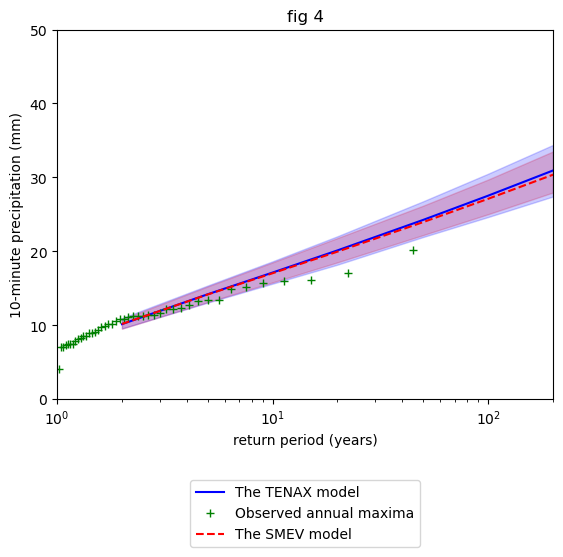

mc 280600: 0.007176876068115234
Elapsed time model_inversion all: 0.4236 seconds


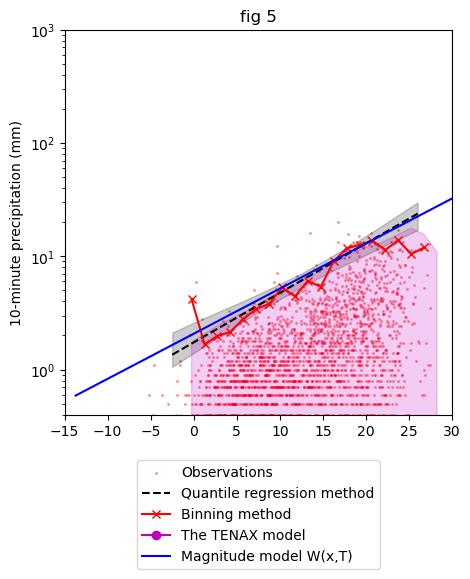

In [17]:
# PLOTTING THE GRAPHS

eT = np.arange(
    np.min(T), np.max(T) + 4, 1
)  # define T values to calculate distributions. +4 to go beyond graph end

# fig 2a
qs = [0.85, 0.95, 0.99, 0.999]
plotting.TNX_FIG_magn_model(P, T, F_phat, thr, eT, qs)
plt.ylabel("10-minute precipitation (mm)")
plt.title("fig 2a")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))
plt.show()

# fig 2b
hist, pdf_values = plotting.TNX_FIG_temp_model(T, g_phat, S.beta, eT)
plt.title("fig 2b")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))
plt.show()

# fig 4
AMS = dict_AMS["10"]  # yet the annual maxima
plotting.TNX_FIG_valid(AMS, S.return_period, RL, smev_RL, RL_unc, smev_RL_unc)
plt.title("fig 4")
plt.ylabel("10-minute precipitation (mm)")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))
plt.show()


# fig 5
iTs = np.arange(-2.5, 37.5, 1.5)  # idk why we need a different T range here
S.n_monte_carlo = np.size(P) * S.niter_smev
_, T_mc, P_mc = S.model_inversion(F_phat, g_phat, n, Ts, gen_P_mc=True, gen_RL=False)
print(f"Elapsed time model_inversion all: {time.time() - start_time:.4f} seconds")
scaling_rate_W, scaling_rate_q = plotting.TNX_FIG_scaling(
    P, T, P_mc, T_mc, F_phat, S.niter_smev, eT, iTs
)
plt.title("fig 5")
plt.ylabel("10-minute precipitation (mm)")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))
plt.show()


## Some more graphs

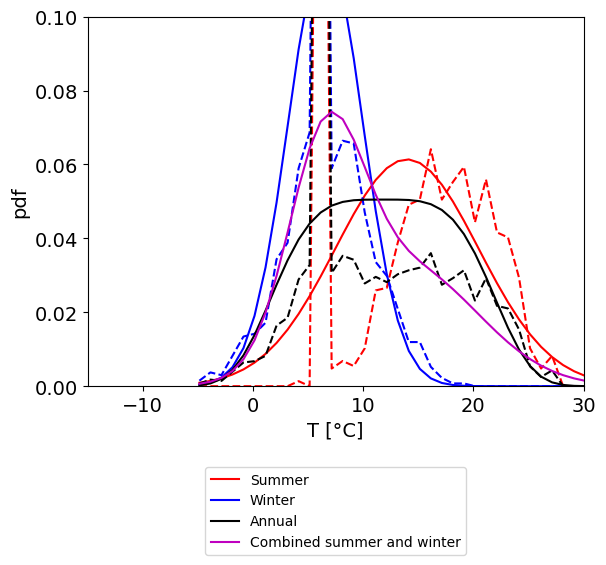

In [16]:
# SPLITTING INTO SUMMER/WINTER
season_separations = [5, 10]
months = dict_ordinary["10"]["oe_time"].dt.month
winter_inds = months.index[
    (months > season_separations[1]) | (months < season_separations[0])
]
summer_inds = months.index[
    (months < season_separations[1] + 1) & (months > season_separations[0] - 1)
]
T_winter = T[winter_inds]
T_summer = T[summer_inds]


g_phat_winter = S.temperature_model(T_winter, beta=2)
g_phat_summer = S.temperature_model(T_summer, beta=2)


winter_pdf = tenax.gen_norm_pdf(eT, g_phat_winter[0], g_phat_winter[1], 2)
summer_pdf = tenax.gen_norm_pdf(eT, g_phat_summer[0], g_phat_summer[1], 2)

combined_pdf = (winter_pdf * np.size(T_winter) + summer_pdf * np.size(T_summer)) / (
    np.size(T_winter) + np.size(T_summer)
)


# fig 3


_, _ = plotting.TNX_FIG_temp_model(
    T=T_summer,
    g_phat=g_phat_summer,
    beta=2,
    eT=eT,
    obscol="r",
    valcol="r",
    obslabel=None,
    vallabel="Summer",
    xlimits=[-15, 30],
    ylimits=[0, 0.1],
)
_, _ = plotting.TNX_FIG_temp_model(
    T=T_winter,
    g_phat=g_phat_winter,
    beta=2,
    eT=eT,
    obscol="b",
    valcol="b",
    obslabel=None,
    vallabel="Winter",
    xlimits=[-15, 30],
    ylimits=[0, 0.1],
)
_, _ = plotting.TNX_FIG_temp_model(
    T=T,
    g_phat=g_phat,
    beta=4,
    eT=eT,
    obscol="k",
    valcol="k",
    obslabel=None,
    vallabel="Annual",
    xlimits=[-15, 30],
    ylimits=[0, 0.1],
)
plt.plot(eT, combined_pdf, "m", label="Combined summer and winter")

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

plt.show()

## Model validation

In [17]:
# TENAX MODEL VALIDATION
S.n_monte_carlo = 20000  # set number of MC for getting RL
yrs = dict_ordinary["10"]["oe_time"].dt.year
yrs_unique = np.unique(yrs)
midway = yrs_unique[
    int(np.ceil(np.size(yrs_unique) / 2)) - 1
]  # -1 to adjust indexing because this returns a sort of length

# DEFINE FIRST PERIOD
P1 = P[yrs <= midway]
T1 = T[yrs <= midway]
AMS1 = AMS[AMS["year"] <= midway]
n_ordinary_per_year1 = n_ordinary_per_year[n_ordinary_per_year.index <= midway]
n1 = n_ordinary_per_year1.sum() / len(n_ordinary_per_year1)

# DEFINE SECOND PERIOD
P2 = P[yrs > midway]
T2 = T[yrs > midway]
AMS2 = AMS[AMS["year"] > midway]
n_ordinary_per_year2 = n_ordinary_per_year[n_ordinary_per_year.index > midway]
n2 = n_ordinary_per_year2.sum() / len(n_ordinary_per_year2)


g_phat1 = S.temperature_model(T1)
g_phat2 = S.temperature_model(T2)


F_phat1, loglik1, _, _ = S.magnitude_model(P1, T1, thr)
RL1, _, _ = S.model_inversion(F_phat1, g_phat1, n1, Ts)


F_phat2, loglik2, _, _ = S.magnitude_model(P2, T2, thr)
RL2, _, _ = S.model_inversion(F_phat2, g_phat2, n2, Ts)

if F_phat[1] == 0:  # check if b parameter is 0 (shape=shape_0*b
    dof = 3
    alpha1 = 1  # b parameter is not significantly different from 0; 3 degrees of freedom for the LR test
else:
    dof = 4
    alpha1 = 0  # b parameter is significantly different from 0; 4 degrees of freedom for the LR test


# check magnitude model the same in both periods
lambda_LR = -2 * (loglik - (loglik1 + loglik2))
pval = chi2.sf(lambda_LR, dof)
if pval > S.alpha:
    print(f"p={pval}. Magnitude models not  different at {S.alpha*100}% significance.")
else:
    print(f"p={pval}. Magnitude models are different at {S.alpha*100}% significance.")

# modelling second model based on first magnitude and changes in mean/std
mu_delta = np.mean(T2) - np.mean(T1)
sigma_factor = np.std(T2) / np.std(T1)

g_phat2_predict = [g_phat1[0] + mu_delta, g_phat1[1] * sigma_factor]
RL2_predict, _, _ = S.model_inversion(F_phat1, g_phat2_predict, n2, Ts)

p=8.24715080048568e-09. Magnitude models are different at 5.0% significance.


## Figures

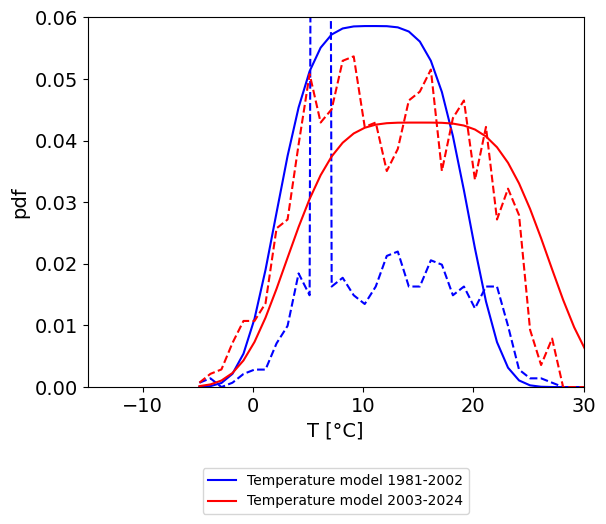

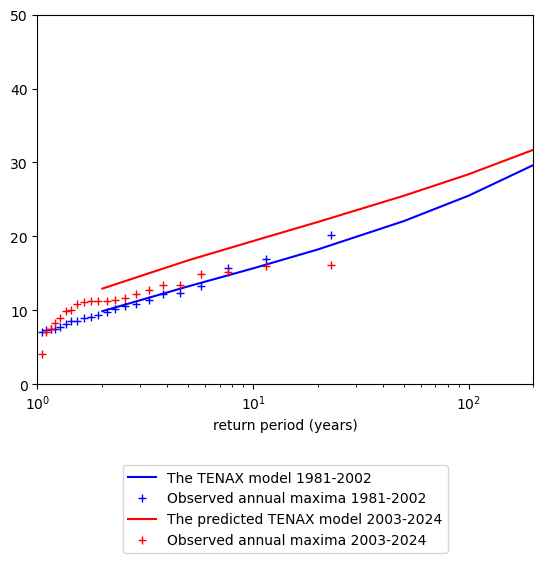

In [18]:
# fig 7a

_, _ = plotting.TNX_FIG_temp_model(
    T=T1,
    g_phat=g_phat1,
    beta=4,
    eT=eT,
    obscol="b",
    valcol="b",
    obslabel=None,
    vallabel="Temperature model " + str(yrs_unique[0]) + "-" + str(midway),
)
_, _ = plotting.TNX_FIG_temp_model(
    T=T2,
    g_phat=g_phat2_predict,
    beta=4,
    eT=eT,
    obscol="r",
    valcol="r",
    obslabel=None,
    vallabel="Temperature model " + str(midway + 1) + "-" + str(yrs_unique[-1]),
)  # model based on temp ave and std changes

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))
plt.show()  # this is slightly different in code and paper I think.. using predicted T vs fitted T

# fig 7b

plotting.TNX_FIG_valid(
    AMS1,
    S.return_period,
    RL1,
    TENAXcol="b",
    obscol_shape="b+",
    TENAXlabel="The TENAX model " + str(yrs_unique[0]) + "-" + str(midway),
    obslabel="Observed annual maxima " + str(yrs_unique[0]) + "-" + str(midway),
)
plotting.TNX_FIG_valid(
    AMS2,
    S.return_period,
    RL2_predict,
    TENAXcol="r",
    obscol_shape="r+",
    TENAXlabel="The predicted TENAX model "
    + str(midway + 1)
    + "-"
    + str(yrs_unique[-1]),
    obslabel="Observed annual maxima " + str(midway + 1) + "-" + str(yrs_unique[-1]),
)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

plt.show()


## Sensitivity Analysis

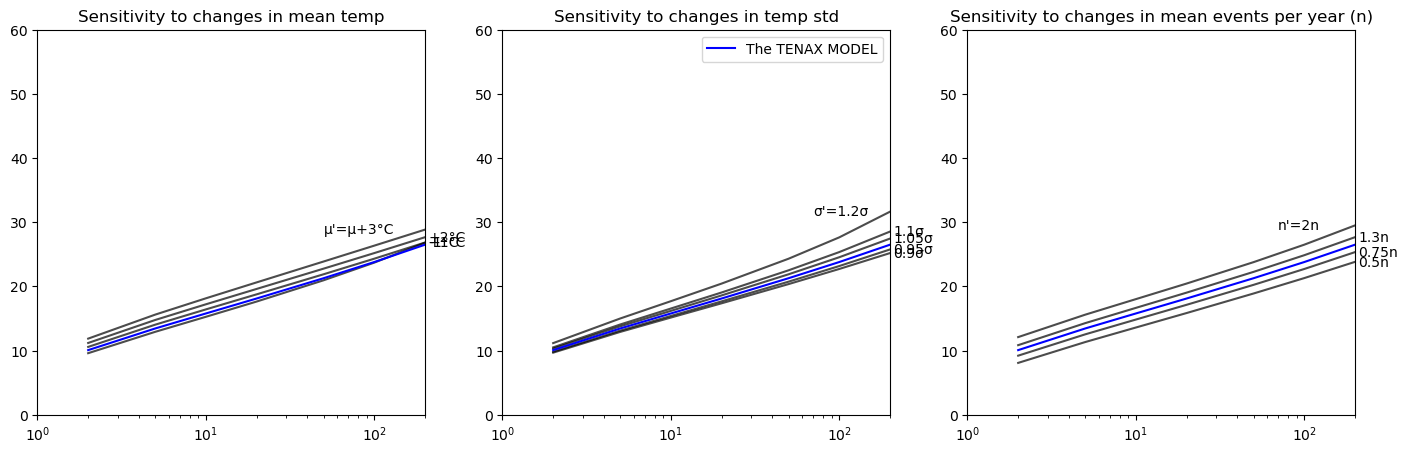

In [19]:
# SENSITIVITY ANALYSIS

# changes in T mean, std, and n to chekc sensitivity
delta_Ts = [-1, 1, 2, 3]
delta_as = [0.9, 0.95, 1.05, 1.1, 1.2]
delta_ns = [0.5, 0.75, 1.3, 2]

# T mean sensitivity
T_sens = np.zeros([np.size(delta_Ts), np.size(S.return_period)])
i = 0
while i < np.size(delta_Ts):
    T_sens[i, :], _, _ = S.model_inversion(
        F_phat, [g_phat[0] + delta_Ts[i], g_phat[1]], n, Ts
    )
    i = i + 1

# T std sensitivity

as_sens = np.zeros([np.size(delta_as), np.size(S.return_period)])
i = 0
while i < np.size(delta_as):
    as_sens[i, :], _, _ = S.model_inversion(
        F_phat, [g_phat[0], g_phat[1] * delta_as[i]], n, Ts
    )
    i = i + 1

# n sensitivity
n_sens = np.zeros([np.size(delta_ns), np.size(S.return_period)])
i = 0
while i < np.size(delta_ns):
    n_sens[i, :], _, _ = S.model_inversion(F_phat, g_phat, n * delta_ns[i], Ts)
    i = i + 1


# fig 6
fig = plt.figure(figsize=(17, 5))
ax1 = fig.add_subplot(1, 3, 1)
i = 0
while i < np.size(delta_Ts) - 1:
    ax1.plot(S.return_period, T_sens[i], "k", alpha=0.7)
    plt.text(
        S.return_period[-1] + 10,
        T_sens[i][-1],
        "{0:+}".format(delta_Ts[i]) + "°C",
        ha="left",
        va="center",
    )
    i = i + 1
# plot last one differently
ax1.plot(S.return_period, T_sens[i], "k", alpha=0.7)
plt.text(
    S.return_period[-3],
    T_sens[i][-1],
    "μ'=μ" + "{0:+}".format(delta_Ts[i]) + "°C",
    ha="left",
    va="center",
)

plt.xscale("log")
ax1.plot(S.return_period, RL, "b")
ax1.set_title("Sensitivity to changes in mean temp")
plt.xscale("log")
plt.xlim(1, 200)
plt.ylim(0, 60)

ax2 = fig.add_subplot(1, 3, 2)
i = 0
while i < np.size(delta_as) - 1:
    ax2.plot(S.return_period, as_sens[i], "k", alpha=0.7)
    plt.text(
        S.return_period[-1] + 10,
        as_sens[i][-1],
        str(delta_as[i]) + "σ",
        ha="left",
        va="center",
    )
    i = i + 1
ax2.plot(S.return_period, as_sens[i], "k", alpha=0.7)
plt.text(
    S.return_period[-3] + 20,
    as_sens[i][-1],
    "σ'=" + str(delta_as[i]) + "σ",
    ha="left",
    va="center",
)


plt.xscale("log")
ax2.plot(S.return_period, RL, "b", label="The TENAX MODEL")
ax2.set_title("Sensitivity to changes in temp std")
plt.legend()
plt.xscale("log")
plt.xlim(1, 200)
plt.ylim(0, 60)

ax3 = fig.add_subplot(1, 3, 3)
i = 0
while i < np.size(delta_ns) - 1:
    ax3.plot(S.return_period, n_sens[i], "k", alpha=0.7, label=str(delta_ns[i]))
    plt.text(
        S.return_period[-1] + 10,
        n_sens[i][-1],
        str(delta_ns[i]) + "n",
        ha="left",
        va="center",
    )
    i = i + 1

ax3.plot(S.return_period, n_sens[i], "k", alpha=0.7)
plt.text(
    S.return_period[-3] + 20,
    n_sens[i][-1],
    "n'=" + str(delta_ns[i]) + "n",
    ha="left",
    va="center",
)

plt.xscale("log")
ax3.plot(S.return_period, RL, "b")
ax3.set_title("Sensitivity to changes in mean events per year (n)")
plt.xscale("log")
plt.xlim(1, 200)
plt.ylim(0, 60)

plt.show()

# TODO: n looks a litte different from in paper